In [22]:
import os
from glob import glob
from torch.utils.data import Dataset
import decord
from ultralytics import YOLO
from IPython.display import display, clear_output
import time
from PIL import Image
from torch.utils.data import DataLoader
import cv2

In [5]:
# Manejando el dataset
TESTING = True

if TESTING:
    GROUPS = ["gg", "La bika me persigue"]
else:
    GROUPS = None

DATA_ROOT = "./data"

def get_video_files(data_root, groups_filter):
    video_paths = []

    for group in os.listdir(data_root):
        group_dir = os.path.join(data_root, group)

        if not os.path.isdir(group_dir):
            continue

        if groups_filter is not None and group not in groups_filter:
            continue

        sessions = glob(os.path.join(group_dir, "session_*", "screen.mkv"))
        video_paths.extend(sessions)

    return video_paths

videos = get_video_files(DATA_ROOT, GROUPS)

print("Videos encontrados:")
for v in videos:
    print(v)
print(f"Total: {len(videos)}")


Videos encontrados:
./data/gg/session_20251026_080319/screen.mkv
./data/gg/session_20251026_075801/screen.mkv
./data/gg/session_20251026_075012/screen.mkv
./data/gg/session_20251026_075620/screen.mkv
./data/gg/session_20251026_075727/screen.mkv
./data/gg/session_20251026_080105/screen.mkv
./data/gg/session_20251026_075348/screen.mkv
./data/gg/session_20251026_075325/screen.mkv
./data/gg/session_20251026_075905/screen.mkv
./data/gg/session_20251026_075518/screen.mkv
./data/gg/session_20251026_074331/screen.mkv
./data/gg/session_20251026_075058/screen.mkv
./data/gg/session_20251026_075453/screen.mkv
./data/gg/session_20251026_080235/screen.mkv
./data/gg/session_20251026_075949/screen.mkv
Total: 15


## Dataset

In [55]:
decord.bridge.set_bridge("torch")

class MKVDataset(Dataset):
    def __init__(self, video_paths, clip_len=16):
        self.video_paths = video_paths
        self.clip_len = clip_len

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        vr = decord.VideoReader(video_path)
        num_frames = len(vr)
        if num_frames <= self.clip_len:
            start = 0
            end = num_frames
        else:
            start = min(800, num_frames - self.clip_len)
            end = start + self.clip_len

        # frames = vr.get_batch(range(len(vr)))
        frames = vr.get_batch(range(start, end))
        return frames

dataset = MKVDataset(videos, clip_len=100)



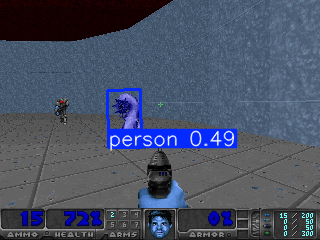

In [56]:
model = YOLO("/home/marcelino.maita/courses/deep_learning/lab2/try_4/runs/train/yolo11l_obb/weights/best.pt")

frame = dataset[0][15] # Fram 15 del primer video
frame_img = frame.byte().cpu().numpy()

results = model(frame_img, verbose = False, conf=0.40)
results[0].show()

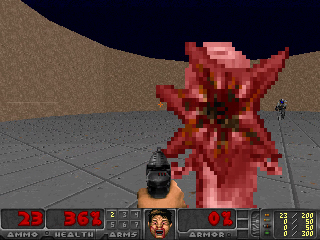

In [57]:
loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)
output_path = "videico.mp4"

clip_wanted = 5
index =0

for clips in loader:
    index+=1
    if index != clip_wanted:
        continue
    
    clip = clips[0]
    num_frames = clip.shape[0]

    frame_h, frame_w = clip[0].shape[0], clip[0].shape[1]

    # Video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30, (frame_w, frame_h))

    for i in range(num_frames):
        frame = clip[i]
        frame_img = frame.byte().cpu().numpy()

        results = model(frame_img, verbose=False, conf=0.40)

        annotated_frame = results[0].plot()

        #Video
        out.write(cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

        img = Image.fromarray(annotated_frame)
        clear_output(wait=True)
        display(img)

        time.sleep(0.03)
    out.release()
    break
